This is part of the blog series for Object Detection with R-CNN.


<img src="https://farm5.staticflickr.com/4900/45295225774_60a2171338_b.jpg" width="524" height="618" alt="Screen Shot 2018-11-23 at 2.43.29 PM">
Cited from [VGG in TensorFlow](https://www.cs.toronto.edu/~frossard/post/vgg16/). 


In this blog, we are now ready to train our classifier for object detection.
We will use a large pre-trained CNN to extract a fixed-length feature vector from each region, and then create artificial neural networks that mapps the feature vector to the object class.
We will focus on detecting a person.

Here is the outline of this blog.  

- Step 1: Read-in CNN pre-trained model using Keras 
- Step 2: Warp the bounded images exctracted from the selective search
- Step 3: Pre-process the feature matrix and the ground truth matrix
- Step 4: Train a class-specific classifier 
- Step 5: Save trained classifier


### Reference

- [Rich feature hierarchies for accurate object detection and semantic segmentation Tech report (v5)](https://arxiv.org/pdf/1311.2524.pdf)




### Reference: "Object Detection with R-CNN" series in my blog
- [Part 1: Object Detection with Pascal VOC2012 - data preparation and understanding](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_data_preparation_and_understanding.html)


- [Part 2: Object Detection with Pascal VOC2012 - R-CNN overview](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_RCNN_overview.html)


- [Part 3: Object Detection with Pascal VOC2012 - Selective Search](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_selective_search.html)
    - [Implement Local Binary Pattern Descriptor from scratch](https://fairyonice.github.io/implement-lbp-from%20scratch.html)
    
    
- [Part 4: Object Detection with Pascal VOC2012 - CNN feature extraction](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_cnn_feature_extraction.html)


- [Part 5: Object Detection with Pascal VOC2012 - Inference with your own image!](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_inference.html)


### Reference: "Object Detection with R-CNN" series in my Github
- [My Github repository](https://github.com/FairyOnIce/ObjectDetectionRCNN)



## Step 1: Read in CNN pre-trained model 
For each region proposal, [R-CNN](https://arxiv.org/pdf/1311.2524.pdf) proposes to extract 4096-dimensional feature vector from each region proposal from [Alex-Net](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), the winner of the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. 



<blockquote>
The ImageNet project is a large visual database designed for use in visual object recognition software research. The ImageNet project runs an annual software contest, the ImageNet Large Scale Visual Recognition Challenge. 
</blockquote>


Since the R-CNN paper was published in 2012, there were quite some improvement in the ILSVRC, and Alex-Net is somewhat obsolete. In this blog post, I will rather use VGGNet to extract features. VGGNet (2014) is the runner-up at the ILSVRC 2014 competition is dubbed VGGNet by the community and was developed by Simonyan and Zisserman.
VGGNet consists of 16 convolutional layers and is very appealing because of its very uniform architecture. 


### VGGNet

<img src="https://farm5.staticflickr.com/4900/45295225774_60a2171338_b.jpg" width="524" height="618" alt="Screen Shot 2018-11-23 at 2.43.29 PM">
Cited from [VGG in TensorFlow](https://www.cs.toronto.edu/~frossard/post/vgg16/). 

Similar to AlexNet, VGGNet uses only 3x3 convolutions. However, VGGNet has a lot more filters. See the model arthiceture above. It contains 16 layers with trainable weights. It is currently the most preferred choice in the community for extracting features from images. The weight configuration of the VGGNet is publicly available, including in [Keras](https://keras.io/applications/#vgg16), and has been used in many other applications and challenges as a baseline feature extractor.


So let's get started with extracting the VGGNet.


In [1]:
import numpy as np
import pandas as pd
import os, sys 
import scipy.misc
import matplotlib.pyplot as plt
import random
import imageio
import skimage
print(sys.version)

3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## Read-in VGGNet using Keras API
It only takes two lines of code.

VGG16() method below download pre-trained weights if it is not yet downloaded. 
Note: "16" stands for the number of layers with parameters. 
[VGG16() method parameters](https://keras.io/applications/#vgg16)
- include_top: whether to include the 3 fully-connected layers at the top of the network.
- weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet).

modelvgg.summary() method shows the summary of the VGGNet architecture. 
For each layer, it shows how many parameters are involved.
Notice that most of the parameters come from the last two fully connected layers. 

In [2]:
from keras.applications import VGG16
modelvgg16 = VGG16(include_top=True,weights='imagenet')
modelvgg16.summary()

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
blo

VGGNet is developed for ILSVRC so its network is designed to classify images into 1,000 different classes. 
As I am not using VGGNet for the sake of the classification but I just need it for extracting features, I will remove the last and the second the last layer from the network.


In "Performance layer-by-layer without fine-turning" section of R-CNN paper, there is some discussion on which layer to use in Alex-Net to extract CNN features. 
They mentioned that removing the final two fully connected layers and use only the pool layer as CNN features for object detection can yield as good performance. They say:
<blockquote>
Much of the CNN's representational power comes from its convolutional layers, rather than from the much larger densely connected layers.
</blockquote>

Nevertheless, I will remove the last one fully connected layer and use the first fully connected layer output as the CNN Features. 
The next codes remove the last two layers.

In [3]:
from keras import models
modelvgg = models.Model(inputs  =  modelvgg16.inputs, 
                        outputs = modelvgg16.layers[-3].output)
## show the deep learning model
modelvgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Step 2: Warp the resions proposed by the selective search
The above model summary above shows that the input layer of the VGG16 requires that image has to be of the shape (height, width, Nchannel) = (224,224,3).

The selective search region proposal from [Part 1: Object Detection with Pascal VOC2012 - data preparation and understanding](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_data_preparation_and_understanding.html) does not necesarilly yield the image of height and width 224. 
In order to compute CNN features for a region proposal, we need to first convert the image data in that region into a form that is compatible. 
R-CNN paper suggests that we warp all pixels in the region proposal to the CNN's input size, regardless of the size or aspect ratio of the region.

Let's read in one of the image from the JPEGImages folder, run selective search region proposal, warp the image and then create CNN features. 

I will run the selective search on an image to extract around 2,000 region proposals as suggested by R-CNN paper. 
I put all the modules for the selective search from [Part 1: Object Detection with Pascal VOC2012 - data preparation and understanding](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_data_preparation_and_understanding.html) at
[My Github account for selective search](https://github.com/FairyOnIce/ObjectDetectionRCNN/blob/master/selective_search.py). 
Please download this file, and save it in the current directory as selective_search.py, then run the codes below. 
ss.get_region_proposal will yield all the region proposals.
We need to warp each candidate region. 

In [4]:
## the codes from Part 3 blog: https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_selective_search.html
import selective_search as ss

img_dir   = "VOCdevkit/VOC2012/JPEGImages"
imgnm     = "2012_002870.jpg"

# import 8 bits degital image (each digit ranges between 0 - 255)
img_8bit  = imageio.imread(os.path.join(img_dir,imgnm))
## region proposal codes 
regions  = ss.get_region_proposal(img_8bit,min_size=50)
print("{} candidate regions are proposed.".format(len(regions)))

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


1985 candidate regions are proposed.


#### Visualize the warped images  together with the original region proposal
As there are quite a few region candidates (1985!), I will only pick five for plotting. 

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


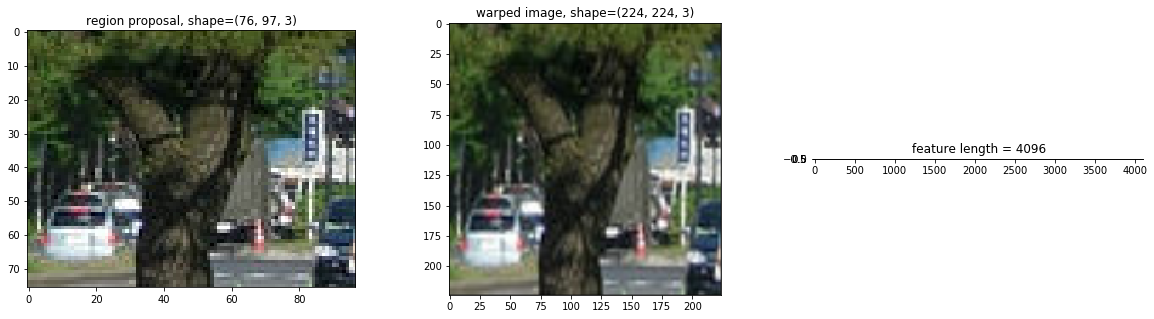

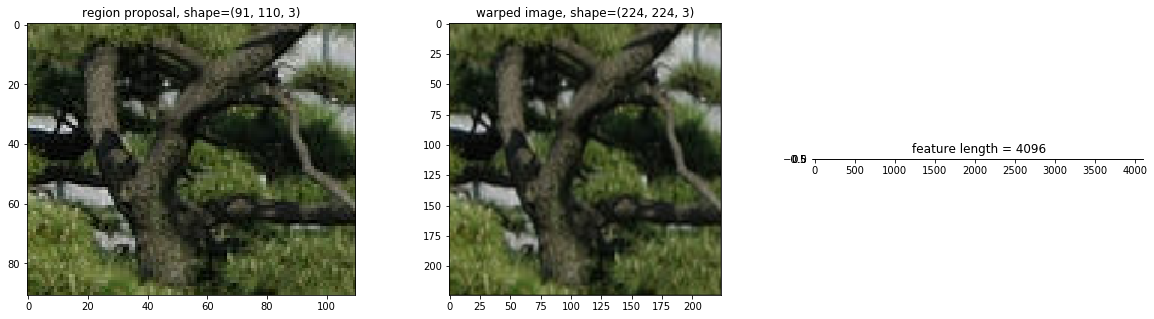

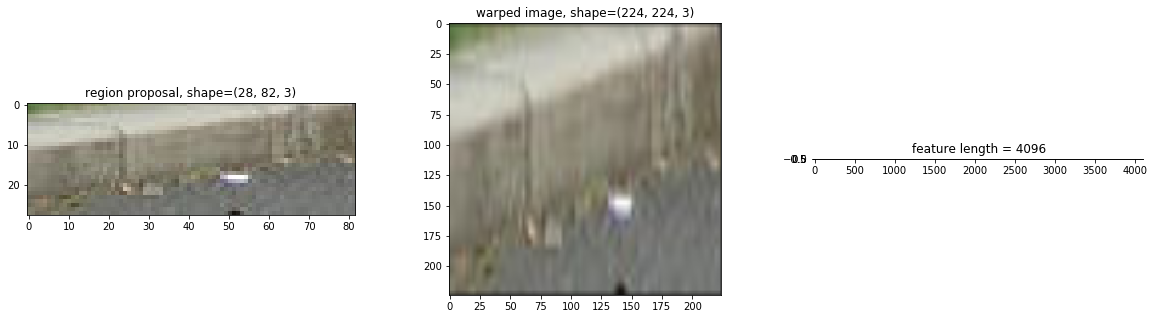

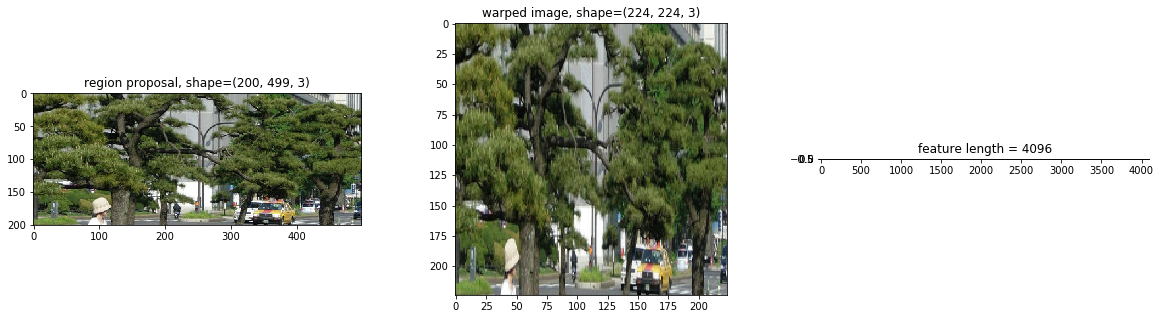

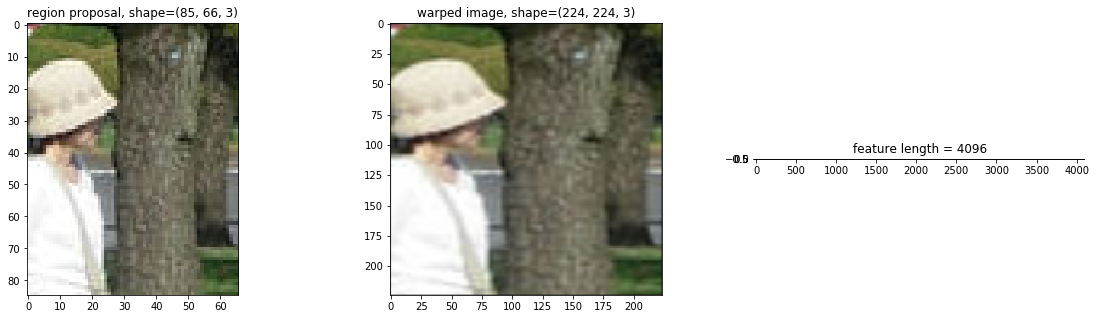

In [5]:

def warp(img, newsize):
    '''
    warp image 
    
    
    img     : np.array of (height, width, Nchannel)
    newsize : (height, width)
    '''
    img_resize = skimage.transform.resize(img,newsize)
    return(img_resize)


warped_size = (224, 224)
X = []
for i in [1511,1654,1713,1692,1757]:
    r = regions[i]
    ## extract a single candidate region
    x , y , width, height = r["rect"]
    img_bb     = img_8bit[y:y + height,x:x + width]
    ## warp image
    img_warped = warp(img_bb, warped_size)
    ## create CNN feature
    feature = modelvgg.predict(img_warped.reshape(1,warped_size[0],warped_size[1],3))
    
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_bb)
    ax.set_title("region proposal, shape={}".format(img_bb.shape))
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(img_warped)
    ax.set_title("warped image, shape={}".format(img_warped.shape))

    ax = fig.add_subplot(1,3,3)    
    ax.imshow(feature, cmap='hot')
    ax.set_title("feature length = {}".format(len(feature.flatten())))
    plt.show()

# Step 3: Pre-process the feature matrix and the ground truth matrix
OK now, we understand how to extract CNN features from each candidate region.
Now using these features, let's create a classifier to identify objects.
To make the problem easy, I will only focus on "person" class and create a binary classifier.

#### To train classifier with CNN features as input, we need corresponding ground truth label out of each candidate region. 
If a region is tighly enclosing a person object, such a region should be considered as a positive example.
While, the region is not containing any part of the person, such a region should be considered as negative example. But what about when a portion of the person is inside of the region?

R-CNN paper discusses this case as follow:

<blockquote>
Less clear is how to label a region that partially oberlaps [the object].
We resolve this issue with an [Intersection over Union (IoU)] overlap threshold, below which regions are defined as negatives. 
The overlap threshold, 0.3, was selected by a grid search over {0,0.1,...,0.5} on a validation set. 
We found that selecting this threshold carefully is important. 
</blockquote>

To understand their strategy, we need to understand IoU. 
IoU is a common metric to measure how similar our predicted bounding box is to the ground truth bounding box.
See explanation at: [Intersection over Union](http://ronny.rest/tutorials/module/localization_001/iou/). I will cite their self-explanatory diagram here:
<img src="https://farm5.staticflickr.com/4839/46007894091_39ba95c082_b.jpg" width="352" alt="Screen Shot 2018-11-22 at 7.02.28 PM">


Now let's get started!
Read in the annotation file created in [Part 1: Object Detection with Pascal VOC2012 - data preparation and understanding](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_data_preparation_and_understanding.html).


In [6]:
# location to save df_anno.csv
import pandas as pd
dir_preprocessed = "VOCdevkit/VOC2012"
df_anno = pd.read_csv(os.path.join(dir_preprocessed,"df_anno.csv"))

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245,250,255,260,265,270,275,280) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### For simplicty, we only look at person class and ignore the other classes in VOC2012.

In [7]:
cols_bbx = []
for colnm in df_anno.columns:
    if "name" in colnm:
        cols_bbx.append(colnm)
bbx_has_personTF = df_anno[cols_bbx].values == "person"
pick = np.any(bbx_has_personTF,axis=1)
df_anno_person = df_anno.loc[pick,:]

We will create training features and ground truth into a 4 pickled objects:
- image0: a list containing all the candidate regions that **contain a person object** i.e., IOU > 0.75
    - Having too many candidate regions for the same object in training data would not add too much new infomation to the model.
    So I only select a single candidate region for each object.
- info0: the infomation corresponding to this particular object captured in image0
- image1: a list containing all the candidate regions that ** does not contain a person object ** i.e., IOU < 0.4
- info 1: the infomation corresponding to this particular object that was not captured in image0

In order to avoid having too many candidate regions that do not contain any object, I will downsample the regions not containing objects such that: 

N of regions containing a person object : N of regions not containing a person object ~= 1 : 2
Note: N_img_without_obj (roughly) determins this ratio, 1 : N_img_without_obj.

As the codes below require considerable time, we will save the results in the folder

**dir_result**

The following codes assume that the current folder contains "result" folder.

In [ ]:
import pickle
IoU_cutoff_object     = 0.7
IoU_cutoff_not_object = 0.4
objnms = ["image0","info0","image1","info1"]  
dir_result = "result"

In [ ]:
import time 
start = time.time()   
# the "rough" ratio between the region candidate with and without objects.
N_img_without_obj = 2 
newsize = (300,400) ## hack
image0, image1, info0,info1 = [], [], [], [] 
for irow in range(df_anno_person.shape[0]):
    ## extract a single frame that contains at least one person object
    row  = df_anno_person.iloc[irow,:]
    ## read in the corresponding frame
    path = os.path.join(img_dir,row["fileID"] + ".jpg")
    img  = imageio.imread(path)
    orig_h, orig_w, _ = img.shape
    ## to reduce the computation speed,
    ## I will do a small hack here. I will resize all the images into newsize = (200,250)    
    img  = warp(img, newsize)
    orig_nh, orig_nw, _ = img.shape
    ## region candidates for this frame
    regions = ss.get_region_proposal(img,min_size=50)[::-1]
    
    ## for each object that exists in the data,
    ## find if the candidate regions contain the person
    for ibb in range(row["Nobj"]): 

        name = row["bbx_{}_name".format(ibb)]
        if name != "person": ## if this object is not person, move on to the next object
            continue 
        if irow % 50 == 0:
            print("frameID = {:04.0f}/{}, BBXID = {:02.0f},  N region proposals = {}, N regions with an object gathered till now = {}".format(
                    irow, df_anno_person.shape[0], ibb, len(regions), len(image1)))
        
        ## extract the bounding box of the person object  
        multx, multy  = orig_nw/orig_w, orig_nh/orig_h 
        true_xmin     = row["bbx_{}_xmin".format(ibb)]*multx
        true_ymin     = row["bbx_{}_ymin".format(ibb)]*multy
        true_xmax     = row["bbx_{}_xmax".format(ibb)]*multx
        true_ymax     = row["bbx_{}_ymax".format(ibb)]*multy
        
        
        person_found_TF = 0
        _image1 = None
        _image0, _info0  = [],[]
        ## for each candidate region, find if this person object is included
        for r in regions:
            
            prpl_xmin, prpl_ymin, prpl_width, prpl_height = r["rect"]
            ## calculate IoU between the candidate region and the object
            IoU = ss.get_IOU(prpl_xmin, prpl_ymin, prpl_xmin + prpl_width, prpl_ymin + prpl_height,
                             true_xmin, true_ymin, true_xmax, true_ymax)
            ## candidate region numpy array
            img_bb = np.array(img[prpl_ymin:prpl_ymin + prpl_height,
                                  prpl_xmin:prpl_xmin + prpl_width])
            
            info = [irow, prpl_xmin, prpl_ymin, prpl_width, prpl_height]
            if IoU > IoU_cutoff_object:
                _image1 = img_bb
                _info1  = info
                break
            elif IoU < IoU_cutoff_not_object:
                _image0.append(img_bb) 
                _info0.append(info) 
        if _image1 is not None:
            # record all the regions with the objects
            image1.append(_image1)
            info1.append(_info1)
            if len(_info0) >= N_img_without_obj: ## record only 2 regions without objects
                # downsample the candidate regions without object 
                # so that the training does not have too much class imbalance. 
                # randomly select N_img_without_obj many frames out of all the sampled images without objects.
                pick = np.random.choice(np.arange(len(_info0)),N_img_without_obj)
                image0.extend([_image0[i] for i in pick ])    
                info0.extend( [_info0[i]  for i in pick ])  

        
end = time.time()  
print("TIME TOOK : {}MIN".format((end-start)/60))

### Save image0, info0, image1, info1 
objs   = [image0,info0,image1,info1]        
for obj, nm in zip(objs,objnms):
    with open(os.path.join(dir_result ,'{}.pickle'.format(nm)), 'wb') as handle:
        pickle.dump(obj, 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


frameID = 0000/9583, BBXID = 00,  N region proposals = 1137, N regions with an object gathered till now = 0


## Warning! 
The following codes take considerable time!

In [ ]:
def plot_cadidate_regions_in_training(image1,title):
    fig = plt.figure(figsize=(12,12))
    fig.subplots_adjust(hspace=0.0001,
                        wspace=0.0001,
                        left=0,right=1,bottom=0, top=1)
    print(title)
    nw, nh = 10, 10
    count = 1
    for irow in range(100):#np.random.choice(len(image1),nw*nh):
        im  = image1[irow]
        ax  = fig.add_subplot(nh,nw,count)
        ax.imshow(im)
        ax.axis("off")
        count += 1
    plt.show()
plot_cadidate_regions_in_training(image1,title="plot warped cadidate regions with a person object intraining ")
plot_cadidate_regions_in_training(image0,title="plot warped cadidate regions without a person object intraining ")

## Read in the prepared data

In [ ]:
objnms = ["image0","info0","image1","info1"] 
objs  = []
for nm in objnms:
    with open(os.path.join(dir_result,'{}.pickle'.format(nm)), 'rb') as handle:
        objs.append(pickle.load(handle))
image0,info0,image1,info1 = objs 
assert len(image0) == len(info0)
assert len(image1) == len(info1)

print("N candidate regions that has IoU > {} = {}".format(IoU_cutoff_object,len(image0)))
print("N candidate regions that has IoU < {} = {}".format(IoU_cutoff_not_object,len(image0)))


## Warp and create CNN features
Creating CNN features is also going to take considerable time without GPU.

- X: np.array of shape = (Ntraining, 4096)
- y: np.array of shape - (Ntraining, 1)
  -  y[:,0] == 1 if the person object is recorded for this feature else = 0.

In [ ]:
import time
def warp_and_create_cnn_feature(image,modelvgg):
    '''
    image  : np.array of (N image, shape1, shape2, Nchannel )
    shape 1 and shape 2 depend on each image
    '''
    print("-"*10)
    print("warp_and_create_cnn_feature")
    start = time.time()
    print("len(image)={}".format(len(image)))
    print("**warp image**")
    for irow in range(len(image)):
        image[irow] = warp(image[irow],warped_size)
    image = np.array(image)
    print("**create CNN features**")
    feature = modelvgg.predict(image)
    print("DONE!")
    print("  feature.shape={}".format(feature.shape))
    end = time.time()
    print("  Time Took = {:5.2f}MIN".format((end - start)/60.0))
    print("")
    return(feature)

feature1 = warp_and_create_cnn_feature(image1,modelvgg)
feature0 = warp_and_create_cnn_feature(image0,modelvgg)

N_obj = len(feature1)
## stack the two set of data
## the first Nobj rows contains the person objects
X = np.concatenate((feature1,feature0))
y = np.zeros((X.shape[0],1))
y[:N_obj,0] = 1


## Save data
print("X.shape={}, y.shape={}".format(X.shape,y.shape))
np.save(file = os.path.join(dir_result,"X.npy"),arr = X)
np.save(file = os.path.join(dir_result,"y.npy"),arr = y)

## Load the CNN feature matrix and corresponding ground truth.

In [ ]:
X = np.load(file = os.path.join(dir_result,"X.npy"))
y = np.load(file = os.path.join(dir_result,"y.npy"))

Shuffle the order of X and y and then split the data (X, y) between training and testing data.
I will use 80% of the data as training data.

In [ ]:
prop_train = 0.8

## shuffle the order of X and y
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

#X, y = X, y[:,[0]]

Ntrain = int(X.shape[0]*prop_train)
X_train, y_train, X_test, y_test = X[:Ntrain], y[:Ntrain], X[Ntrain:], y[Ntrain:]

# Step 4: Train a class-specific classifier 
Congratuations! You came really far, and the most difficult parts are already over.


In [ ]:
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense

# define the architecture of the network
model = Sequential()
model.add(Dense(32, input_dim=4096, init="uniform",activation="relu"))
model.add(Dense(32, activation="relu", kernel_initializer="uniform"))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test,y_test),
                    batch_size      = 64,
                    nb_epoch        = 50,
                    verbose         = 2)

### Visualize trajectories of the validation and training losses over epochs

In [ ]:
fig = plt.figure(figsize=(20,5))
ax  = fig.add_subplot(1,2,1)
for key in ["val_loss","loss"]:
    ax.plot(history.history[key],label=key)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.legend()
ax  = fig.add_subplot(1,2,2)
for key in ["val_acc","acc"]:
    ax.plot(history.history[key],label=key)
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
plt.legend()

plt.show()

## Step 5: Save trained classifier

In [ ]:
model.save(os.path.join(dir_result,"classifier.h5"))
print("Saved model to disk")

## Next step, how can we improve the model performance?
### Domain-specific fince-tuning
In the original R-CNN paper, the CNN features are extracted from "fine-tuned" Alex-Net. 
To adapt the Alex-Net to the new task (object detection with different classes), and the new domain (warped proposal windows), the R-CNN paper continues stochastic gradient descent training of the CNN parameters using only warped region proposals. 
During this domain specific fine-tuning, CNN's ImageNet-specific 1000 nodes classification layer is replaced by the 20 + 1 nodes classification layer (20 = the number of classes in VOC and 1 = background). 
The details of the fine tuning is discussed in Section 2.3. Training of [Rich feature hierarchies for accurate object detection and semantic segmentation Tech report (v5)](https://arxiv.org/pdf/1311.2524.pdf). 
In this blog post, I skipped this fine-tuning process for the sake of the simplicity. But the original paper says that "the improvement is striking". Therefore, the fine tuning is definitely the next step.
